In [26]:
from mace.calculators import mace_mp
from ase import build

from ase.md import Langevin
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase import units
from ase import Atoms
from ase.build import bulk
from ase.visualize import view
import numpy as np
import matplotlib.pyplot as plt
from ase.build import add_vacuum
from ase.optimize import LBFGS, BFGS
from ase import Atom

from ase.io.trajectory import Trajectory
from ase.md import Langevin, Bussi
from ase import io

from mace.calculators import mace_mp
macemp_FT = mace_mp(dispersion=True, default_dtype="float64", model="FT_models/MACE_medium_newE0s_revPBE_D3_300.model")


Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
Using TorchDFTD3Calculator for D3 dispersion corrections


/Users/joehart/Desktop/0_Cambridge/0_MPhil_Scientific_Computing/Written_assignments/Fine-Tuning-MACE/notebooks_FT/venv_mace/lib/python3.12/site-packages/mace/calculators/mace.py:139: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


In [399]:
plt.rcParams.update({
    "font.family": "serif",       
    "font.size": 16,              
    "axes.labelsize": 16,         
    "axes.titlesize": 16,         
    "xtick.labelsize": 14,        
    "ytick.labelsize": 14,       
    "legend.fontsize": 14,      
    "text.usetex": True       
})

In [4]:
caco3_frame = io.read("caco3-water/revPBE-D3/gen2.xyz", index="1")

In [27]:
io.write("CaCO3_frame.xyz", caco3_frame)

In [120]:
caco3_frame = io.read("CaCO3_frame.xyz")

In [453]:
view(caco3_frame, viewer="x3d")

In [17]:
caco3_frame.cell

Cell([14.081269264221191, 14.081269264221191, 14.081269264221191])

In [707]:
print("No. water molecules = ", (len(caco3_frame) - 5) / 3)

No. water molecules =  98.0


### RDF: Ca-O

In [ ]:
from ase.neighborlist import neighbor_list

def compute_rdf_optimized(atoms_list, i_indices, j_indices, r_max=6.0, bins=100):
    i_indices = np.array(i_indices)
    j_indices = np.array(j_indices)

    all_distances = []
    total_pairs = 0
    volume = atoms_list[0].get_volume()
    rho = len(j_indices) / volume  # Number density of j-type atoms
    
    for atoms in atoms_list:
        i_list, j_list, dists = neighbor_list('ijd', atoms, r_max)

        mask = np.isin(i_list, i_indices) & np.isin(j_list, j_indices)  # Select pairs (i, j)
        valid_distances = dists[mask]
        all_distances.append(valid_distances)
        total_pairs += len(valid_distances)


    all_distances = np.concatenate(all_distances)

    hist, bin_edges = np.histogram(all_distances, bins=bins, range=(0, r_max))
    r = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    bin_width = bin_edges[1] - bin_edges[0]

    # ideal gas normalization factor
    shell_volumes = 4 * np.pi * r**2 * bin_width
    ideal_gas_distribution = shell_volumes * rho

    rdf = hist / (ideal_gas_distribution * total_pairs)

    return r, rdf


Fine-tuned

In [461]:
traj_FT_300 = io.read("caco3_traj/CaCO3_modified_nocomvel_120000.traj", index = "2000:5000")
traj_FT_100 = io.read("caco3_traj/CaCO3_modified_FT_100_120000.traj", index = "2000:5000")
traj_FT_10 = io.read("caco3_traj/CaCO3_modified_FT_10_120000.traj", index = "2000:5000")
traj_FT_50 = io.read("caco3_traj/CaCO3_modified_FT_50_120000.traj", index = "2000:5000")


In [ ]:
ca_indices_FT_10 = [atom.index for atom in traj_FT_10[0] if atom.symbol == 'Ca']
o_indices_FT_10 = [atom.index for atom in traj_FT_10[0] if atom.symbol == 'O']

print(f"Found {len(ca_indices_FT_10)} Ca atoms and {len(o_indices_FT_10)} O atoms.")

r_FT_10, rdf_FT_10 = compute_rdf_optimized(traj_FT_10, ca_indices_FT_10, o_indices_FT_10, r_max=6.0, bins=100)


Found 1 Ca atoms and 84 O atoms.


In [ ]:
ca_indices_FT_50 = [atom.index for atom in traj_FT_50[0] if atom.symbol == 'Ca']
o_indices_FT_50 = [atom.index for atom in traj_FT_50[0] if atom.symbol == 'O']

print(f"Found {len(ca_indices_FT_50)} Ca atoms and {len(o_indices_FT_50)} O atoms.")

r_FT_50, rdf_FT_50 = compute_rdf_optimized(traj_FT_50, ca_indices_FT_50, o_indices_FT_50, r_max=6.0, bins=100)

Found 1 Ca atoms and 84 O atoms.


In [ ]:
ca_indices_FT_100 = [atom.index for atom in traj_FT_100[0] if atom.symbol == 'Ca']
o_indices_FT_100 = [atom.index for atom in traj_FT_100[0] if atom.symbol == 'O']

print(f"Found {len(ca_indices_FT_100)} Ca atoms and {len(o_indices_FT_100)} O atoms.")

r_FT_100, rdf_FT_100 = compute_rdf_optimized(traj_FT_100, ca_indices_FT_100, o_indices_FT_100, r_max=6.0, bins=100)

Found 1 Ca atoms and 84 O atoms.


In [ ]:
ca_indices_FT_300 = [atom.index for atom in traj_FT_300[0] if atom.symbol == 'Ca']
o_indices_FT_300 = [atom.index for atom in traj_FT_300[0] if atom.symbol == 'O']

print(f"Found {len(ca_indices_FT_300)} Ca atoms and {len(o_indices_FT_300)} O atoms.")

r_FT_300, rdf_FT_300 = compute_rdf_optimized(traj_FT_300, ca_indices_FT_300, o_indices_FT_300, r_max=6.0, bins=100)

Found 1 Ca atoms and 84 O atoms.


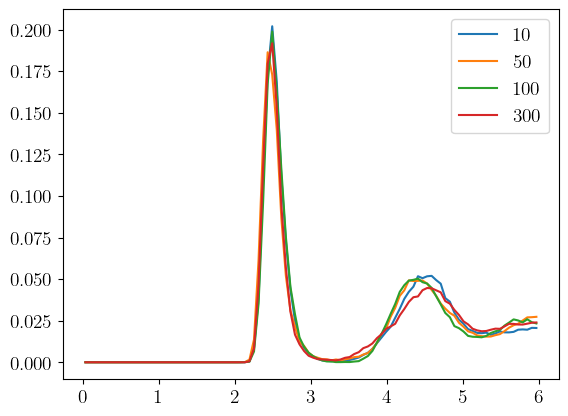

In [457]:
plt.plot(r_FT_10, rdf_FT_10, label = "10")
plt.plot(r_FT_50, rdf_FT_50, label = "50")
plt.plot(r_FT_100, rdf_FT_100, label = "100")
plt.plot(r_FT_300, rdf_FT_300, label = "300")
plt.legend()

scratch

In [ ]:
traj_scratch_300 = io.read("caco3_traj/CaCO3_modified_scratch_300_120000.traj", index="2000:5000")
traj_scratch_100 = io.read("caco3_traj/CaCO3_modified_scratch_100_120000.traj", index="2000:5000")
traj_scratch_10 = io.read("caco3_traj/CaCO3_modified_scratch_10_120000.traj", index="2000:5000")
traj_scratch_50 = io.read("caco3_traj/CaCO3_modified_scratch_50_120000.traj", index="2000:5000")


In [ ]:
ca_indices_scratch_10 = [atom.index for atom in traj_scratch_10[0] if atom.symbol == 'Ca']
o_indices_scratch_10 = [atom.index for atom in traj_scratch_10[0] if atom.symbol == 'O']

print(f"Found {len(ca_indices_scratch_10)} Ca atoms and {len(o_indices_scratch_10)} O atoms.")

r_scratch_10, rdf_scratch_10 = compute_rdf_optimized(traj_scratch_10, ca_indices_scratch_10, o_indices_scratch_10, r_max=6.0, bins=200)

Found 1 Ca atoms and 84 O atoms.


In [ ]:
ca_indices_scratch_50 = [atom.index for atom in traj_scratch_50[0] if atom.symbol == 'Ca']
o_indices_scratch_50 = [atom.index for atom in traj_scratch_50[0] if atom.symbol == 'O']

print(f"Found {len(ca_indices_scratch_50)} Ca atoms and {len(o_indices_scratch_50)} O atoms.")

r_scratch_50, rdf_scratch_50 = compute_rdf_optimized(traj_scratch_50, ca_indices_scratch_50, o_indices_scratch_50, r_max=6.0, bins=200)

Found 1 Ca atoms and 84 O atoms.


In [ ]:
ca_indices_scratch_100 = [atom.index for atom in traj_scratch_100[0] if atom.symbol == 'Ca']
o_indices_scratch_100 = [atom.index for atom in traj_scratch_100[0] if atom.symbol == 'O']

print(f"Found {len(ca_indices_scratch_100)} Ca atoms and {len(o_indices_scratch_100)} O atoms.")

r_scratch_100, rdf_scratch_100 = compute_rdf_optimized(traj_scratch_100, ca_indices_scratch_100, o_indices_scratch_100, r_max=6.0, bins=200)

Found 1 Ca atoms and 84 O atoms.


In [ ]:
ca_indices_scratch_300 = [atom.index for atom in traj_scratch_300[0] if atom.symbol == 'Ca']
o_indices_scratch_300 = [atom.index for atom in traj_scratch_300[0] if atom.symbol == 'O']

print(f"Found {len(ca_indices_scratch_300)} Ca atoms and {len(o_indices_scratch_300)} O atoms.")

r_scratch_300, rdf_scratch_300 = compute_rdf_optimized(traj_scratch_300, ca_indices_scratch_300, o_indices_scratch_300, r_max=6.0, bins=200)

Found 1 Ca atoms and 84 O atoms.


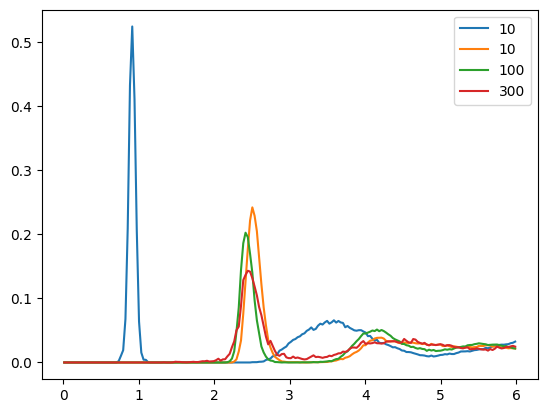

In [ ]:
plt.plot(r_scratch_10, rdf_scratch_10, label="10")
plt.plot(r_scratch_50, rdf_scratch_50, label="50")
plt.plot(r_scratch_100, rdf_scratch_100, label="100")
plt.plot(r_scratch_300, rdf_scratch_300, label="300")
plt.legend()

Combined: scratch + FT

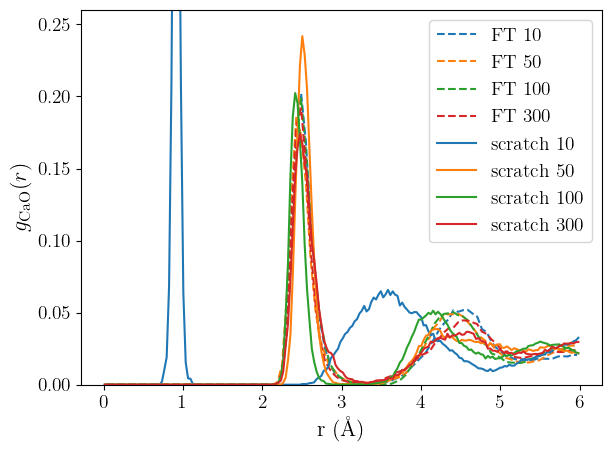

In [676]:
plt.Figure(figsize=(6,5))

plt.plot(r_FT_10, rdf_FT_10, linestyle = "--", label = "FT 10", color = 'C0')
plt.plot(r_FT_50, rdf_FT_50, linestyle = "--", label = "FT 50", color = 'C1')
plt.plot(r_FT_100, rdf_FT_100, linestyle = "--", label = "FT 100", color = 'C2')
plt.plot(r_FT_300, rdf_FT_300, linestyle = "--", label = "FT 300", color = 'C3')

plt.plot(r_scratch_10, rdf_scratch_10, label="scratch 10", color = 'C0')
plt.plot(r_scratch_50, rdf_scratch_50, label="scratch 50", color = 'C1')
plt.plot(r_scratch_100, rdf_scratch_100, label="scratch 100", color = 'C2')
plt.plot(r_scratch_300, rdf_scratch_300, label="scratch 300", color = 'C3')

plt.legend()
plt.xlabel(r'r ($\rm \AA$)')
plt.ylabel(r'$g_{\mathrm{\scriptstyle CaO}}(r)$')
plt.ylim(0,0.26)

plt.tight_layout()
plt.savefig('figures/g_r_ca.pdf')
plt.show()

### RDF: O-O

In [316]:
r_FT_10_oo, rdf_FT_10_oo = compute_rdf_optimized(traj_FT_10, o_indices_FT_10, o_indices_FT_10, r_max=6.0, bins=100)

In [380]:
r_FT_50_oo, rdf_FT_50_oo = compute_rdf_optimized(traj_FT_50, o_indices_FT_50, o_indices_FT_50, r_max=6.0, bins=100)

In [317]:
r_FT_100_oo, rdf_FT_100_oo = compute_rdf_optimized(traj_FT_100, o_indices_FT_100, o_indices_FT_100, r_max=6.0, bins=100)

In [318]:
r_FT_300_oo, rdf_FT_300_oo = compute_rdf_optimized(traj_FT_300, o_indices_FT_300, o_indices_FT_300, r_max=6.0, bins=100)

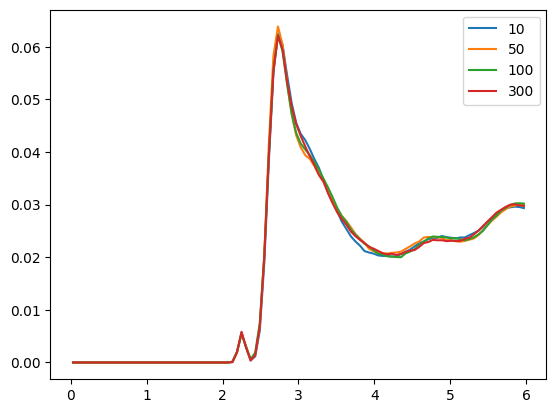

In [387]:
plt.plot(r_FT_10_oo, rdf_FT_10_oo, label = "10")
plt.plot(r_FT_50_oo, rdf_FT_50_oo, label = "50")
plt.plot(r_FT_100_oo, rdf_FT_100_oo, label = "100")
plt.plot(r_FT_300_oo, rdf_FT_300_oo, label = "300")
plt.legend()

In [320]:
r_scratch_10_oo, rdf_scratch_10_oo = compute_rdf_optimized(traj_scratch_10, o_indices_scratch_10, o_indices_scratch_10, r_max=6.0, bins=100)

In [381]:
r_scratch_50_oo, rdf_scratch_50_oo = compute_rdf_optimized(traj_scratch_50, o_indices_scratch_50, o_indices_scratch_50, r_max=6.0, bins=100)

In [321]:
r_scratch_100_oo, rdf_scratch_100_oo = compute_rdf_optimized(traj_scratch_100, o_indices_scratch_100, o_indices_scratch_100, r_max=6.0, bins=100)

In [674]:
r_scratch_300_oo, rdf_scratch_300_oo = compute_rdf_optimized(traj_scratch_300, o_indices_scratch_300, o_indices_scratch_300, r_max=6.0, bins=100)

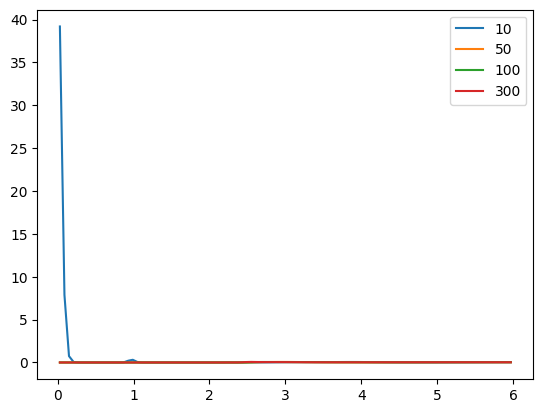

In [388]:
plt.plot(r_scratch_10_oo, rdf_scratch_10_oo, label = "10")
plt.plot(r_scratch_50_oo, rdf_scratch_50_oo, label = "50")
plt.plot(r_scratch_100_oo, rdf_scratch_100_oo, label = "100")
plt.plot(r_scratch_300_oo, rdf_scratch_300_oo, label = "300")
plt.legend()

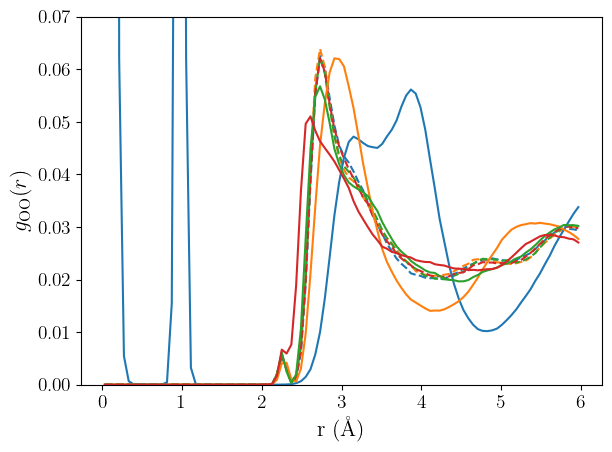

In [675]:
plt.Figure(figsize=(6,5))

plt.plot(r_FT_10_oo, rdf_FT_10_oo, linestyle = "--", label = "FT 10", color = 'C0')
plt.plot(r_FT_50_oo, rdf_FT_50_oo, linestyle = "--", label = "FT 50", color = 'C1')
plt.plot(r_FT_100_oo, rdf_FT_100_oo, linestyle = "--", label = "FT 100", color = 'C2')
plt.plot(r_FT_300_oo, rdf_FT_300_oo, linestyle = "--", label = "FT 300", color = 'C3')

plt.plot(r_scratch_10_oo, rdf_scratch_10_oo, label = "scratch 10", color = 'C0')
plt.plot(r_scratch_50_oo, rdf_scratch_50_oo, label = "scratch 50", color = 'C1')
plt.plot(r_scratch_100_oo, rdf_scratch_100_oo, label = "scratch 100", color = 'C2')
plt.plot(r_scratch_300_oo, rdf_scratch_300_oo, label = "scratch 300", color = 'C3')

plt.ylim(0,0.07)
plt.xlabel(r'r ($\rm \AA$)')
plt.ylabel(r'$g_{\mathrm{\scriptstyle OO}}(r)$')

plt.tight_layout()
#plt.savefig('figures/g_r_oo.pdf')
plt.show()

### MSD of oxygen

In [ ]:
def compute_msd(traj, atom_symbol="O"):

    oxygen_indices = [atom.index for atom in traj[0] if atom.symbol == atom_symbol]

    num_frames = len(traj)
    num_atoms = len(oxygen_indices)
    
    initial_positions = traj[0].get_positions()[oxygen_indices]

    msd_values = np.zeros(num_frames)

    for i, atoms in enumerate(traj):
        current_positions = atoms.get_positions()[oxygen_indices]
        displacements = current_positions - initial_positions
        squared_displacements = np.sum(displacements**2, axis=1)
        msd_values[i] = np.mean(squared_displacements)
    time_steps = np.arange(num_frames)

    return time_steps/100, msd_values

In [336]:
traj_FT_10_MSD = io.read("caco3_traj/CaCO3_modified_FT_10_120000.traj", index = "2000:")
traj_FT_50_MSD = io.read("caco3_traj/CaCO3_modified_FT_50_120000.traj", index = "2000:")
traj_FT_100_MSD = io.read("caco3_traj/CaCO3_modified_FT_100_120000.traj", index = "2000:")
traj_FT_300_MSD = io.read("caco3_traj/CaCO3_modified_nocomvel_120000.traj", index = "2000:")

traj_scratch_10_MSD = io.read("caco3_traj/CaCO3_modified_scratch_10_120000.traj", index="2000:")
traj_scratch_50_MSD = io.read("caco3_traj/CaCO3_modified_scratch_50_120000.traj", index="2000:")
traj_scratch_100_MSD = io.read("caco3_traj/CaCO3_modified_scratch_100_120000.traj", index="2000:")
traj_scratch_300_MSD = io.read("caco3_traj/CaCO3_modified_scratch_120000.traj", index="2000:")


In [383]:
traj_FT_100_250000_MSD = io.read("caco3_traj/CaCO3_modified_FT_100_250000.traj", index = "2000:")

In [ ]:
time_FT_100_250000, avg_msd_FT_100_250000 = compute_msd(traj_FT_100_250000_MSD, atom_symbol="O")


In [ ]:
time_FT_10, avg_msd_FT_10 = compute_msd(traj_FT_10_MSD, atom_symbol="O")
time_FT_50, avg_msd_FT_50 = compute_msd(traj_FT_50_MSD, atom_symbol="O")
time_FT_100, avg_msd_FT_100 = compute_msd(traj_FT_100_MSD, atom_symbol="O")
time_FT_300, avg_msd_FT_300 = compute_msd(traj_FT_300_MSD, atom_symbol="O")

time_scratch_10, avg_msd_scratch_10 = compute_msd(traj_scratch_10_MSD, atom_symbol="O")
time_scratch_50, avg_msd_scratch_50 = compute_msd(traj_scratch_50_MSD, atom_symbol="O")
time_scratch_100, avg_msd_scratch_100 = compute_msd(traj_scratch_100_MSD, atom_symbol="O")
time_scratch_300, avg_msd_scratch_300 = compute_msd(traj_scratch_300_MSD, atom_symbol="O")



In [418]:
time_FT_10_Ca, avg_msd_FT_10_Ca = compute_msd(traj_FT_10_MSD, atom_symbol="Ca")
time_FT_50_Ca, avg_msd_FT_50_Ca = compute_msd(traj_FT_50_MSD, atom_symbol="Ca")
time_FT_100_Ca, avg_msd_FT_100_Ca = compute_msd(traj_FT_100_MSD, atom_symbol="Ca")
time_FT_300_Ca, avg_msd_FT_300_Ca = compute_msd(traj_FT_300_MSD, atom_symbol="Ca")

time_FT_100_250000_Ca, avg_msd_FT_100_250000_Ca = compute_msd(traj_FT_100_250000_MSD, atom_symbol="Ca")


time_scratch_10_Ca, avg_msd_scratch_10_Ca = compute_msd(traj_scratch_10_MSD, atom_symbol="Ca")
time_scratch_50_Ca, avg_msd_scratch_50_Ca = compute_msd(traj_scratch_50_MSD, atom_symbol="Ca")
time_scratch_100_Ca, avg_msd_scratch_100_Ca = compute_msd(traj_scratch_100_MSD, atom_symbol="Ca")
time_scratch_300_Ca, avg_msd_scratch_300_Ca = compute_msd(traj_scratch_300_MSD, atom_symbol="Ca")

/var/folders/br/67qx_45113s31sykxddgpjyw0000gn/T/ipykernel_23140/3568433629.py:39: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(min(time_FT_10), max(time_FT_10))
/var/folders/br/67qx_45113s31sykxddgpjyw0000gn/T/ipykernel_23140/3568433629.py:43: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,100)


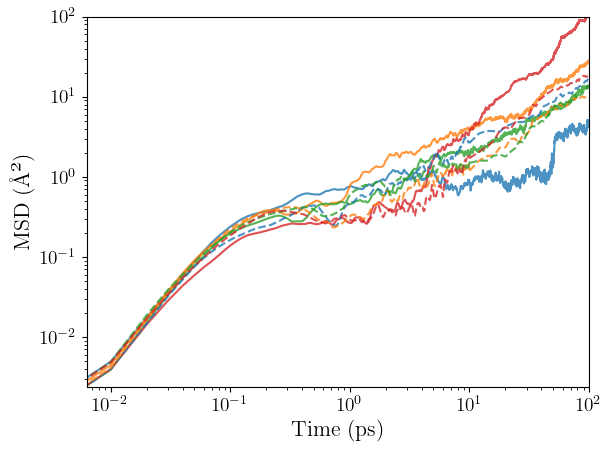

In [706]:
plt.Figure(figsize=(6,5))

# plt.loglog(time_FT_10, avg_msd_FT_10,  linestyle="--", label="FT 10", color = 'C0', alpha = 0.8, zorder = 2)
# plt.loglog(time_FT_50, avg_msd_FT_50, linestyle = "--", label="FT 50", color = 'C1', alpha = 0.8, zorder = 2)
# plt.loglog(time_FT_100, avg_msd_FT_100, linestyle = "--", label="FT 100", color = 'C2', alpha = 0.8, zorder = 2)
# plt.loglog(time_FT_300, avg_msd_FT_300, linestyle = "--", label="FT 300", color = 'C3', alpha = 0.8, zorder = 2)


datasets = {
    "FT 10": ("C0", time_FT_10, avg_msd_FT_10),
    "FT 50": ("C1", time_FT_50, avg_msd_FT_50),
    "FT 100": ("C2", time_FT_100, avg_msd_FT_100),
    "FT 300": ("C3", time_FT_300, avg_msd_FT_300),
}

for label, (color, time_data, msd_data) in datasets.items():
    x_values = np.array(time_data)
    y_values = np.array(msd_data)

    # Find index where x > 10
    idx = np.where(x_values > 10)[0][0] if np.any(x_values > 10) else len(x_values)

    # Plot all points up to x = 10
    plt.loglog(x_values[:idx], y_values[:idx], linestyle="--", label=f"{label} (all points)", color=color, alpha=0.8, zorder=2)

    # Plot every 10th point after x = 10
    plt.loglog(x_values[idx::200], y_values[idx::200], linestyle="--", color=color, alpha=0.8, zorder=2)




plt.loglog(time_scratch_10, avg_msd_scratch_10, label="scratch 10", color = 'C0', alpha = 0.8, zorder=1)
plt.loglog(time_scratch_50, avg_msd_scratch_50, label="scratch 50", color = 'C1', alpha = 0.8, zorder=1)
plt.loglog(time_scratch_100, avg_msd_scratch_100, label="scratch 100", color = 'C2', alpha = 0.8, zorder=1)
plt.loglog(time_scratch_300, avg_msd_scratch_300, label="scratch 300", color = 'C3', alpha = 0.8, zorder=1)


plt.xlabel("Time (ps)")
plt.xlim(min(time_FT_10), max(time_FT_10))

plt.ylabel("MSD (Å²)")
plt.xlabel("Time (ps)")
plt.ylim(0,100)

plt.tight_layout()
plt.savefig('figures/MSD_O.pdf')
plt.show()

plt.show()

/var/folders/br/67qx_45113s31sykxddgpjyw0000gn/T/ipykernel_23140/3771138233.py:20: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,25)


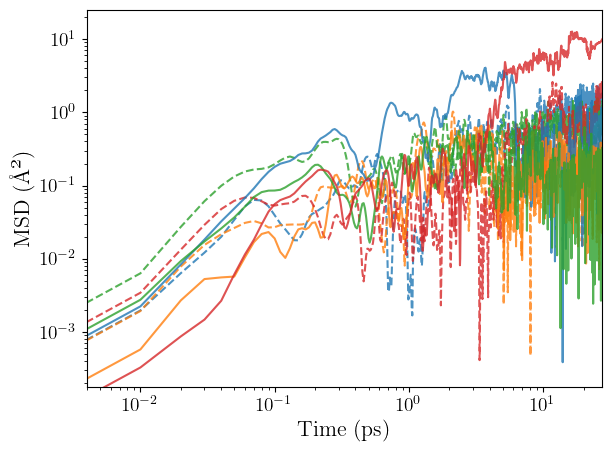

In [440]:
plt.Figure(figsize=(6,5))

plt.loglog(time_FT_10_Ca, avg_msd_FT_10_Ca, linestyle = "--", label="FT 10", color = 'C0', alpha = 0.8)
plt.loglog(time_FT_50_Ca, avg_msd_FT_50_Ca, linestyle = "--", label="FT 50", color = 'C1', alpha = 0.8)
plt.loglog(time_FT_100_Ca, avg_msd_FT_100_Ca, linestyle = "--", label="FT 100", color = 'C2', alpha = 0.8)
plt.loglog(time_FT_300_Ca, avg_msd_FT_300_Ca, linestyle = "--", label="FT 300", color = 'C3', alpha = 0.8)

plt.loglog(time_scratch_10_Ca, avg_msd_scratch_10_Ca, label="scratch 10", color = 'C0', alpha = 0.8)
plt.loglog(time_scratch_50_Ca, avg_msd_scratch_50_Ca, label="scratch 50", color = 'C1', alpha = 0.8)
plt.loglog(time_scratch_100_Ca, avg_msd_scratch_100_Ca, label="scratch 100", color = 'C2', alpha = 0.8)
plt.loglog(time_scratch_300_Ca, avg_msd_scratch_300_Ca, label="scratch 300", color = 'C3', alpha = 0.8)



plt.xlabel("Time (ps)")
plt.xlim(min(values_x_msd), max(values_x_msd))
#plt.legend()
plt.ylabel("MSD (Å²)")
plt.xlabel("Time (ps)")
plt.ylim(0,25)

plt.tight_layout()
plt.savefig('figures/MSD_Ca.pdf')
plt.show()

plt.show()

### Coordination number

- can get free energy by inverting the probability density of beign in each coordination number using - kbT ln(rho)

In [340]:
def compute_CN(R_t, r_CaO_min_1, n, m):
    CN_t = np.sum(
        (1 - (R_t / r_CaO_min_1)**n) / (1 - (R_t / r_CaO_min_1)**m),
        axis=1
    )
    return CN_t

In [556]:
traj_FT_100_250000 = io.read("caco3_traj/CaCO3_modified_FT_100_250000.traj", index = ":")
traj_FT_100_600k_250000 = io.read("caco3_traj/CaCO3_modified_FT_100_600K_250000.traj", index = ":")

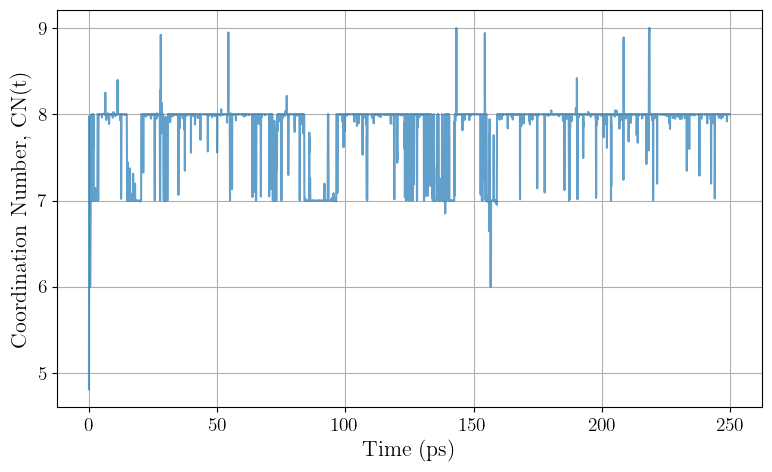

In [ ]:
n = 60
m = 200
r_CaO_min_1 = 3.25

def get_CaO_distances(atoms):
    Ca_indices = [atom.index for atom in atoms if atom.symbol == "Ca"]
    O_indices = [atom.index for atom in atoms if atom.symbol == "O"]

    distances = []
    for ca in Ca_indices:
        for o in O_indices:
            d = atoms.get_distance(ca, o, mic=True)  # minimum image convention
            distances.append(d)
    return np.array(distances)


CN_values = []
for atoms in traj_FT_100_250000:
    R_t = get_CaO_distances(atoms)
    CN_t = np.sum((1 - (R_t / r_CaO_min_1) ** n) / (1 - (R_t / r_CaO_min_1) ** m))
    CN_values.append(CN_t)

CN_values = np.array(CN_values)

plt.Figure(figsize=(6,5))

plt.figure(figsize=(8, 5))
plt.plot(np.array(range(len(CN_values[CN_values>4.5]))) / 100, CN_values[CN_values>4.5], linestyle="-", alpha=0.7)
plt.xlabel("Time (ps)")
plt.ylabel("Coordination Number, CN(t)")
#plt.title("Temporal Evolution of Coordination Number")
plt.grid(True)
plt.tight_layout()
plt.savefig('figures/CN_time.pdf')
plt.show()


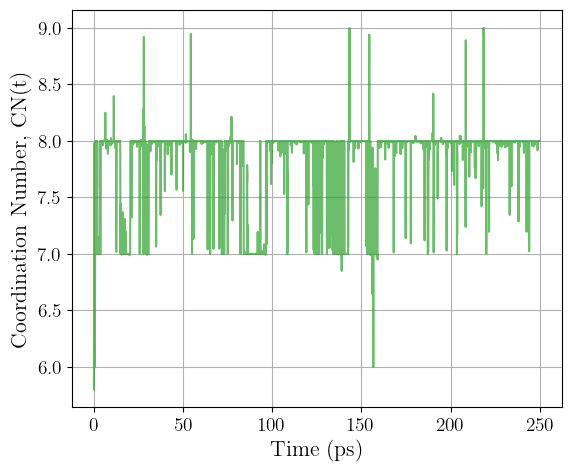

In [476]:
plt.figure(figsize=(6,5))


plt.plot(np.array(range(len(CN_values[CN_values>5.7]))) / 100, CN_values[CN_values>5.7], linestyle="-", alpha=0.7, color = "C2")
plt.xlabel("Time (ps)")
plt.ylabel("Coordination Number, CN(t)")
#plt.title("Temporal Evolution of Coordination Number")
plt.grid(True)
plt.tight_layout()
plt.savefig('figures/CN_time.pdf')
plt.show()

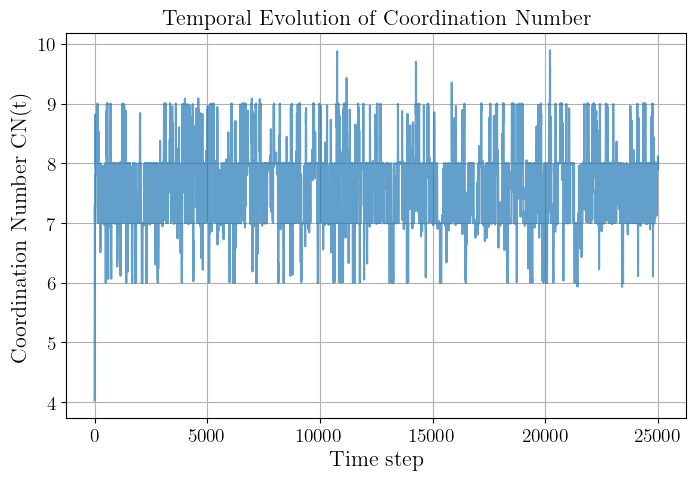

In [ ]:
CN_values_600k = []
for atoms in traj_FT_100_600k_250000:
    R_t = get_CaO_distances(atoms)
    CN_t = np.sum((1 - (R_t / r_CaO_min_1) ** n) / (1 - (R_t / r_CaO_min_1) ** m))
    CN_values_600k.append(CN_t)

CN_values_600k = np.array(CN_values_600k)

# Plot CN evolution over time
plt.figure(figsize=(8, 5))
plt.plot(range(len(CN_values_600k)), CN_values_600k, linestyle="-", alpha=0.7)
plt.xlabel("Time step")
plt.ylabel("Coordination Number CN(t)")
plt.title("Temporal Evolution of Coordination Number")
plt.grid(True)
plt.show()

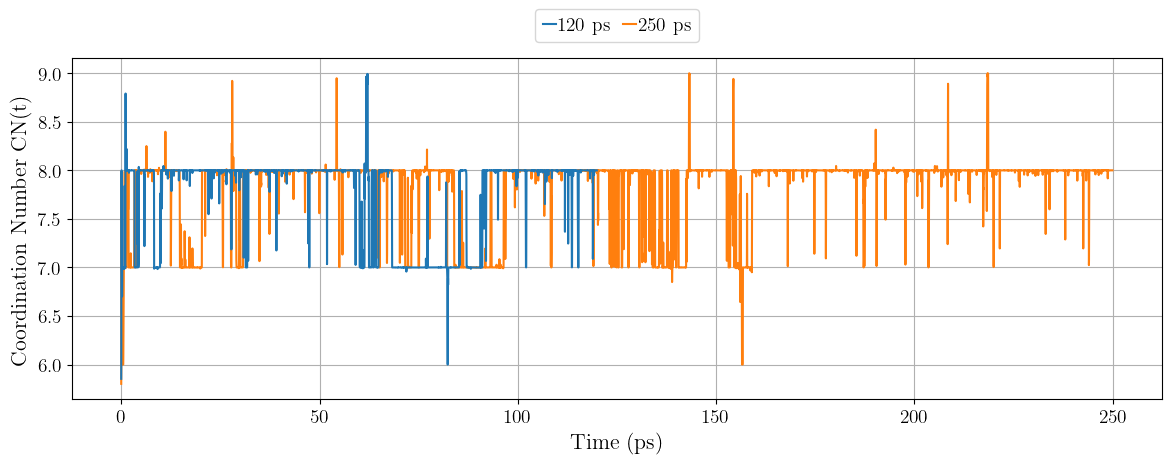

In [669]:
plt.figure(figsize=(12,5))


plt.plot(np.array(range(len(CN_values_FT["100"][CN_values_FT["100"]>5.7])))/100, CN_values_FT["100"][CN_values_FT["100"]>5.7], linestyle="-", alpha=1, color="C0", zorder=3, label = "120 ps")
plt.plot(np.array(range(len(CN_values[CN_values>5.7]))) / 100, CN_values[CN_values>5.7], linestyle="-", alpha=1, color="C1", zorder=2, label = "250 ps")
#plt.plot(np.array(range(len(CN_values_600k[CN_values_600k>5.7])))/100, CN_values_600k[CN_values_600k>5.7], linestyle="-", alpha=1, color="C2", zorder=1, label = "600 K (250 ps)")

plt.xlabel("Time (ps)", fontsize=16)
plt.ylabel("Coordination Number CN(t)", fontsize=16)
plt.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.17), columnspacing=0.6, handletextpad=0.1, handlelength=0.7, fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig("figures/CN_time_300_600.pdf")
plt.show()

/var/folders/br/67qx_45113s31sykxddgpjyw0000gn/T/ipykernel_23140/1968053997.py:13: RuntimeWarning: divide by zero encountered in log
  free_energy = -kB * T * np.log(hist) # J per molecules
/var/folders/br/67qx_45113s31sykxddgpjyw0000gn/T/ipykernel_23140/1968053997.py:19: RuntimeWarning: divide by zero encountered in log
  free_energy_600k = -kB * T * np.log(hist_600k) * (6.03e23) / 1000


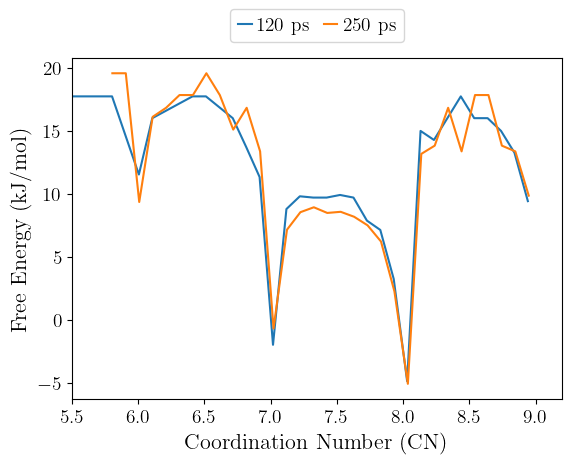

In [ ]:
from scipy.constants import Boltzmann


T = 300 
kB = Boltzmann


bins = np.linspace(min(CN_values), max(CN_values), 50)
hist, bin_edges = np.histogram(CN_values, bins=bins, density=True) 
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  
# Compute free energy using F = -k_B T ln(p)
free_energy = -kB * T * np.log(hist) 
free_energy = free_energy * (6.03e23) / 1000 # KJ/mol

bins_600k = np.linspace(min(CN_values_600k), max(CN_values_600k), 50)  
hist_600k, bin_edges_600k = np.histogram(CN_values_600k, bins=bins_600k, density=True) 
bin_centers_600k = (bin_edges_600k[:-1] + bin_edges_600k[1:]) / 2  
free_energy_600k = -kB * T * np.log(hist_600k) * (6.03e23) / 1000 


plt.figure(figsize=(6,5))

# Plot Free Energy Profile
plt.plot(bin_centres_FT["100"][valid_indices_FT["100"]], free_energy_FT["100"][valid_indices_FT["100"]], linestyle="-", alpha=1, label = "120 ps", color='C0')
plt.plot(bin_centers, free_energy, linestyle="-", alpha=1, label = '250 ps', color = "C1")
#plt.plot(bin_centers_600k, free_energy_600k, linestyle="-", alpha=1, label = '600 K (250 ps)', color = "C2")
plt.xlabel("Coordination Number (CN)", fontsize=16)
plt.ylabel("Free Energy (kJ/mol)", fontsize=16)
#plt.grid(True)
plt.xlim(5.5,9.2)
plt.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.17), columnspacing=0.7, handletextpad=0.3, handlelength=0.7, fontsize=14)
plt.tight_layout()
plt.savefig('figures/CN_free_energy_300_600.pdf')
plt.show()


using 100 ps

In [ ]:
traj_FT_10_all = io.read("caco3_traj/CaCO3_modified_FT_10_120000.traj", index = ":")
traj_FT_50_all = io.read("caco3_traj/CaCO3_modified_FT_50_120000.traj", index = ":")
traj_FT_100_all = io.read("caco3_traj/CaCO3_modified_FT_100_120000.traj", index = ":")
traj_FT_300_all = io.read("caco3_traj/CaCO3_modified_nocomvel_120000.traj", index = ":")

traj_scratch_10_all = io.read("caco3_traj/CaCO3_modified_scratch_10_120000.traj", index=":")
traj_scratch_50_all = io.read("caco3_traj/CaCO3_modified_scratch_50_120000.traj", index=":")
traj_scratch_100_all = io.read("caco3_traj/CaCO3_modified_scratch_100_120000.traj", index=":")
#traj_scratch_300_all = io.read("caco3_traj/CaCO3_modified_scratch_120000.traj", index=":")
traj_scratch_300_all = io.read("caco3_traj/CaCO3_modified_scratch_300_120000.traj", index=":")


In [ ]:
plt.figure(figsize=(8, 5))

FT = {"10": traj_FT_10_all, "50": traj_FT_50_all, "100": traj_FT_100_all, "300": traj_FT_300_all}

CN_values_FT = {"10": [], "50": [], "100": [], "300": []}


for key, traj in zip(FT.keys(), list(FT.values())):
    for atoms in traj:
        R_t = get_CaO_distances(atoms)
        CN_t = np.sum((1 - (R_t / r_CaO_min_1) ** n) / (1 - (R_t / r_CaO_min_1) ** m))
        CN_values_FT[key].append(CN_t)

    CN_values_FT[key] = np.array(CN_values_FT[key])


<Figure size 800x500 with 0 Axes>

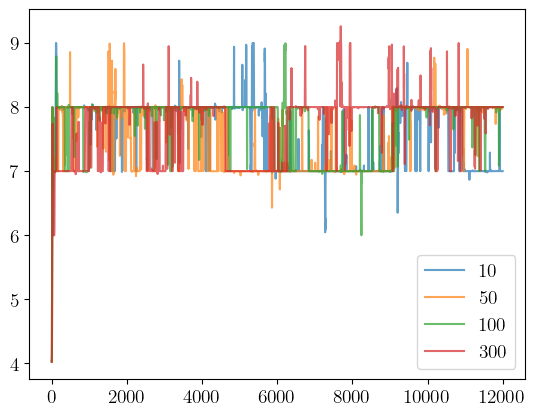

In [543]:
for key, CN_list in zip(CN_values_FT.keys(), list(CN_values_FT.values())):
    plt.plot(range(len(CN_list)), CN_list, linestyle="-", alpha=0.7, label = key)

plt.legend()

In [ ]:
scratch = {"10": traj_scratch_10_all, "50": traj_scratch_50_all, "100": traj_scratch_100_all, "300": traj_scratch_300_all}
CN_values_scratch = {"10": [], "50": [], "100": [], "300": []}


for key, traj in zip(scratch.keys(), list(scratch.values())):
    for atoms in traj:
        R_t = get_CaO_distances(atoms)
        CN_t = np.sum((1 - (R_t / r_CaO_min_1) ** n) / (1 - (R_t / r_CaO_min_1) ** m))
        CN_values_scratch[key].append(CN_t)

    CN_values_scratch[key] = np.array(CN_values_scratch[key])


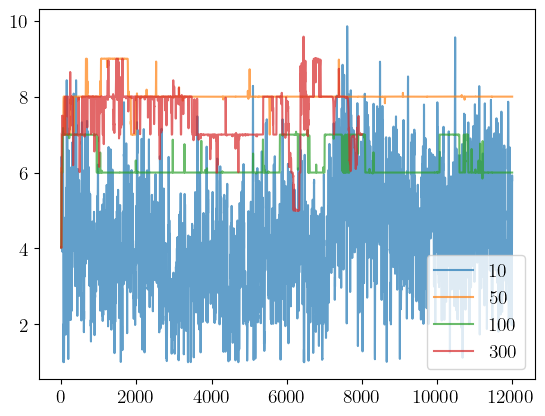

In [569]:
for key, CN_list in zip(CN_values_scratch.keys(), list(CN_values_scratch.values())):
    plt.plot(range(len(CN_list)), CN_list, linestyle="-", alpha=0.7, label = key)

plt.legend()

In [ ]:
T = 300
kB = Boltzmann

free_energy_FT = {"10": [], "50": [], "100": [], "300": []}
bin_centres_FT = {"10": [], "50": [], "100": [], "300": []}
valid_indices_FT = {"10": [], "50": [], "100": [], "300": []}

free_energy_scratch = {"10": [], "50": [], "100": [], "300": []}
bin_centres_scratch = {"10": [], "50": [], "100": [], "300": []}
valid_indices_scratch = {"10": [], "50": [], "100": [], "300": []}


for key, CN_list in zip(CN_values_FT.keys(), list(CN_values_FT.values())):

    bins = np.linspace(min(CN_list), max(CN_list), 50) 
    hist, bin_edges = np.histogram(CN_list, bins=bins, density=True)  
    bin_centres_FT[key] = (bin_edges[:-1] + bin_edges[1:]) / 2  

    # Compute free energy using F = -k_B T ln(p)
    free_energy_FT[key] = -kB * T * np.log(hist) # J per molecules
    free_energy_FT[key] = np.array(free_energy_FT[key]) * (6.03e23) / 1000 # KJ/mol
    valid_indices_FT[key] = np.isfinite(free_energy_FT[key])

for key, CN_list in zip(CN_values_scratch.keys(), list(CN_values_scratch.values())):

    bins = np.linspace(min(CN_list), max(CN_list), 50)  
    hist, bin_edges = np.histogram(CN_list, bins=bins, density=True)  
    bin_centres_scratch[key] = (bin_edges[:-1] + bin_edges[1:]) / 2  

    free_energy_scratch[key] = -kB * T * np.log(hist)
    free_energy_scratch[key] = np.array(free_energy_scratch[key]) * (6.03e23) / 1000
    valid_indices_scratch[key] = np.isfinite(free_energy_scratch[key])


/var/folders/br/67qx_45113s31sykxddgpjyw0000gn/T/ipykernel_23140/1506960464.py:20: RuntimeWarning: divide by zero encountered in log
  free_energy_FT[key] = -kB * T * np.log(hist) # J per molecules
/var/folders/br/67qx_45113s31sykxddgpjyw0000gn/T/ipykernel_23140/1506960464.py:31: RuntimeWarning: divide by zero encountered in log
  free_energy_scratch[key] = -kB * T * np.log(hist) # J per molecules


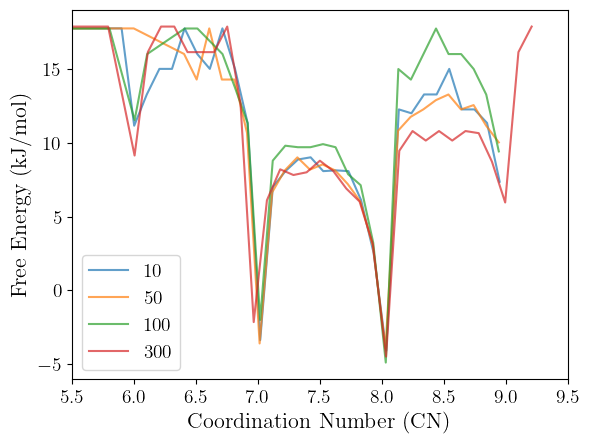

In [578]:
for key, free_energy, bin_centre in zip(free_energy_FT.keys(), list(free_energy_FT.values()), list(bin_centres_FT.values())):

    plt.plot(bin_centre[valid_indices_FT[key]], free_energy[valid_indices_FT[key]], linestyle="-", alpha=0.7, label = key)
    plt.xlabel("Coordination Number (CN)")
    plt.ylabel("Free Energy (kJ/mol)")
    plt.xlim(5.5,9.5)

plt.legend()



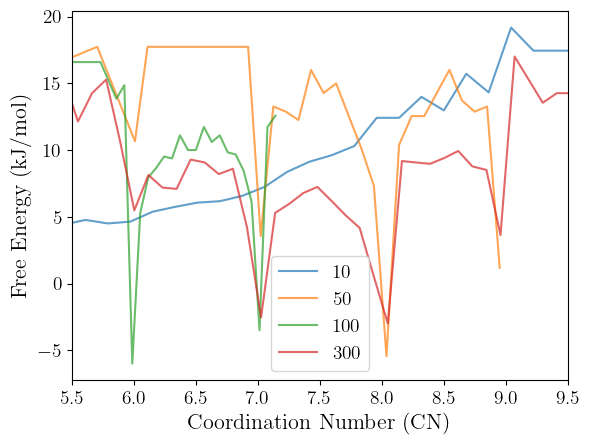

In [579]:
for key, free_energy, bin_centre in zip(free_energy_scratch.keys(), list(free_energy_scratch.values()), list(bin_centres_scratch.values())):

    plt.plot(bin_centre[valid_indices_scratch[key]], free_energy[valid_indices_scratch[key]], linestyle="-", alpha=0.7, label = key)
    plt.xlabel("Coordination Number (CN)")
    plt.ylabel("Free Energy (kJ/mol)")
    plt.xlim(5.5,9.5)

plt.legend()

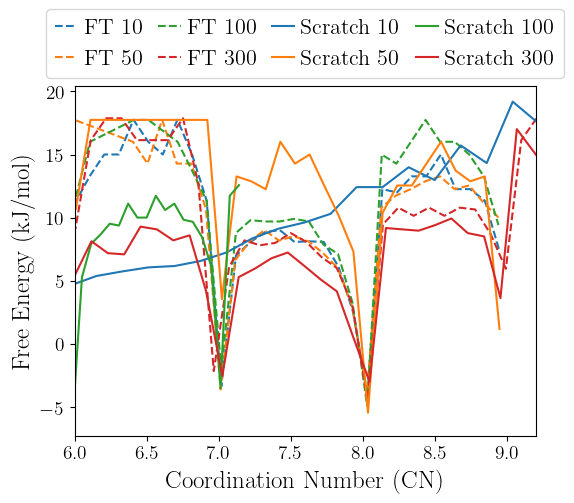

In [648]:
plt.figure(figsize=(6,5.5))

i = 0
for key, free_energy, bin_centre in zip(free_energy_FT.keys(), list(free_energy_FT.values()), list(bin_centres_FT.values())):

    plt.plot(bin_centre[valid_indices_FT[key]], free_energy[valid_indices_FT[key]], linestyle="--", alpha=1, label = f"FT {key}", color = f"C{i}")
    i+=1

i = 0
for key, free_energy, bin_centre in zip(free_energy_scratch.keys(), list(free_energy_scratch.values()), list(bin_centres_scratch.values())):

    plt.plot(bin_centre[valid_indices_scratch[key]], free_energy[valid_indices_scratch[key]], linestyle="-", alpha=1, label = f"Scratch {key}", color = f"C{i}")
    i+=1

plt.xlabel("Coordination Number (CN)", fontsize=18)
plt.ylabel("Free Energy (kJ/mol)", fontsize=18)
plt.xlim(6,9.2)
#plt.legend()
plt.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.25), columnspacing=0.7, handletextpad=0.3, handlelength=1, fontsize=16)
plt.tight_layout()
plt.savefig('figures/CN_free_energy_all.pdf')
plt.show()